In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoModel, AutoTokenizer

In [2]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)
model.eval()

print(f"Model: {model_name}")
print(f"Layers: {model.config.num_hidden_layers}")
print(f"Attention heads: {model.config.num_attention_heads}")

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model: bert-base-uncased
Layers: 12
Attention heads: 12


In [3]:
def get_attention(text, model, tokenizer):
    """Extract attention matrices from all layers and heads."""
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    with torch.no_grad():
        outputs = model(**inputs)

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    attentions = outputs.attentions

    return {
        "tokens": tokens,
        "attentions": attentions,
        "num_layers": len(attentions),
        "num_heads": attentions[0].shape[1],
    }

In [4]:
text = "The cat sat on the mat and looked at the dog"
result = get_attention(text, model, tokenizer)

print(f"Text: {text}")
print(f"Tokens: {result['tokens']}")
print(f"Layers: {result['num_layers']}, Heads per layer: {result['num_heads']}")
print(f"Attention matrix shape: {result['attentions'][0].shape}")

Text: The cat sat on the mat and looked at the dog
Tokens: ['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', 'and', 'looked', 'at', 'the', 'dog', '[SEP]']
Layers: 12, Heads per layer: 12
Attention matrix shape: torch.Size([1, 12, 13, 13])


In [ ]:
def plot_attention_heatmap(attentions, tokens, layer, head):
    """Plot attention heatmap for a specific layer and head."""
    attn_matrix = attentions[layer][0, head].numpy()

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        attn_matrix,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap="viridis",
        vmin=0,
        vmax=1,
        ax=ax,
    )
    ax.set_title(f"Layer {layer}, Head {head}")
    ax.set_xlabel("Key (attended to)")
    ax.set_ylabel("Query (attending from)")
    plt.tight_layout()
    plt.show()

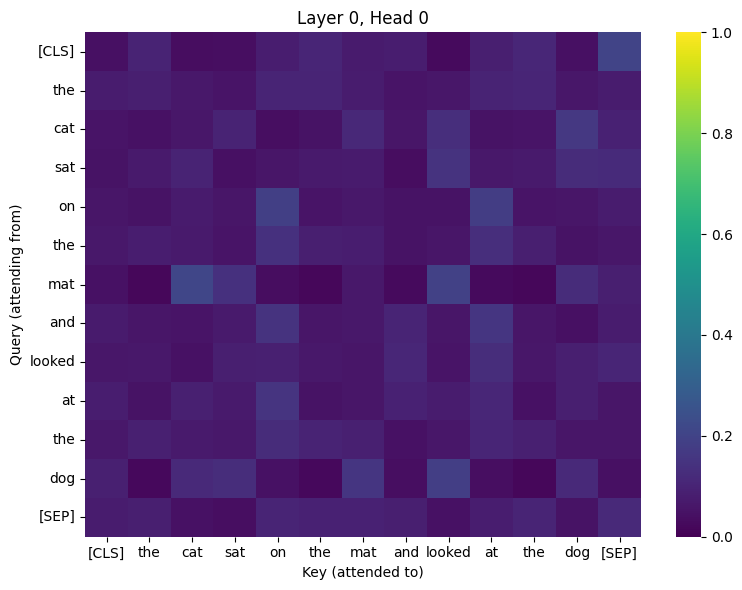

In [6]:
plot_attention_heatmap(result["attentions"], result["tokens"], layer=0, head=0)

In [7]:
def plot_attention_heads_grid(attentions, tokens, layer):
    """Plot all 12 attention heads of a single layer in a 3x4 grid."""
    fig, axes = plt.subplots(3, 4, figsize=(20, 14))

    for head in range(12):
        ax = axes[head // 4, head % 4]
        attn_matrix = attentions[layer][0, head].numpy()

        sns.heatmap(
            attn_matrix,
            xticklabels=tokens,
            yticklabels=tokens,
            cmap="viridis",
            vmin=0,
            vmax=1,
            ax=ax,
            cbar=False,
        )
        ax.set_title(f"Head {head}", fontsize=10)
        ax.tick_params(labelsize=7)

    fig.suptitle(f"All attention heads — Layer {layer}", fontsize=14)
    plt.tight_layout()
    plt.show()

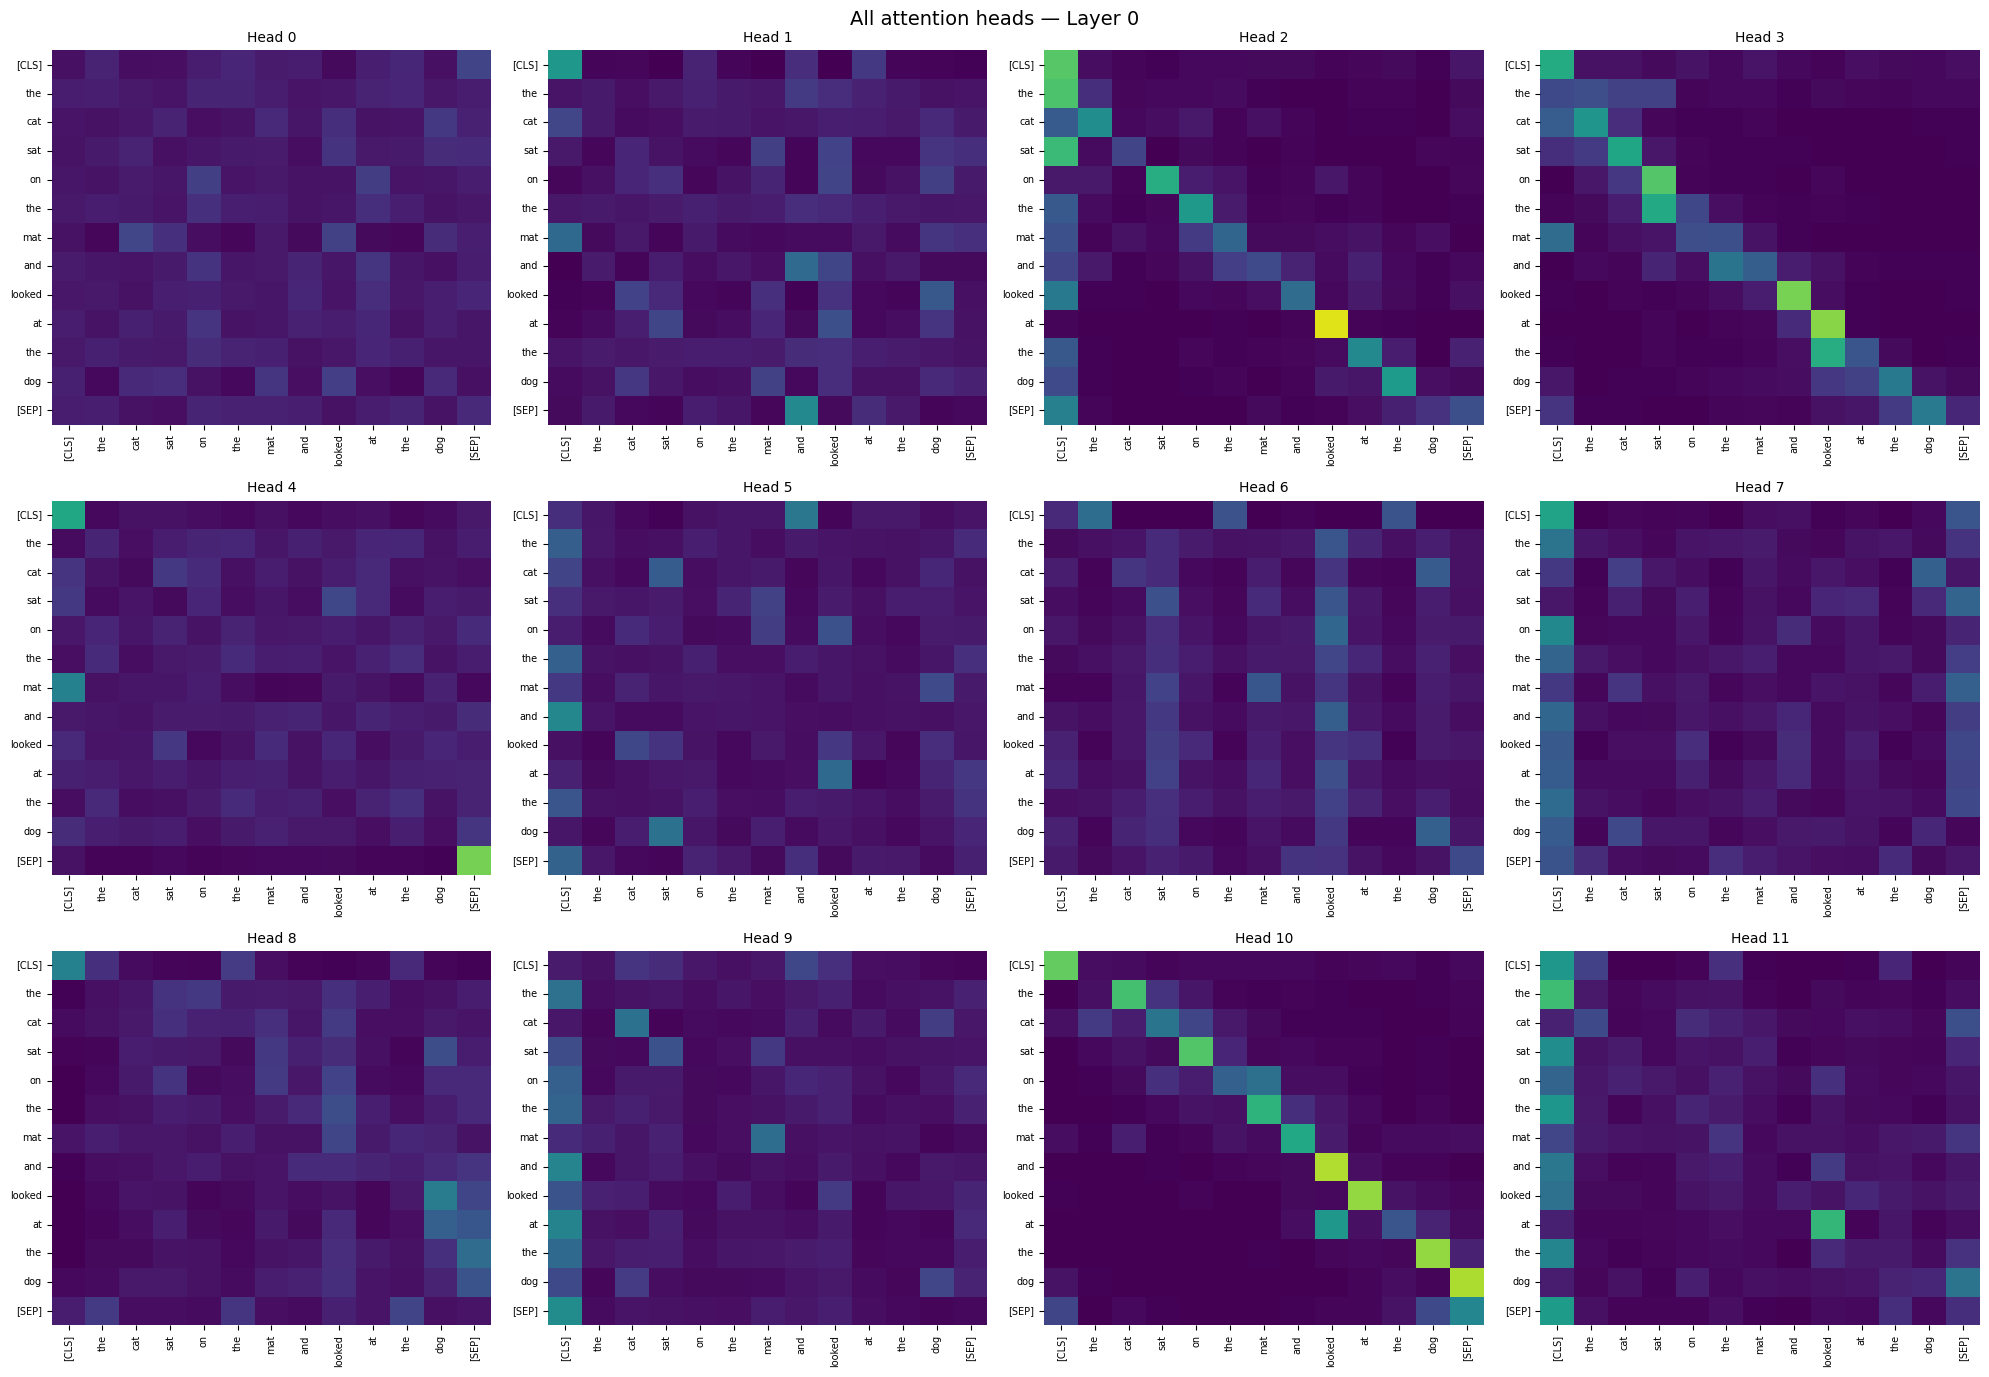

In [8]:
plot_attention_heads_grid(result["attentions"], result["tokens"], layer=0)

## Analysis — Early vs Late layers


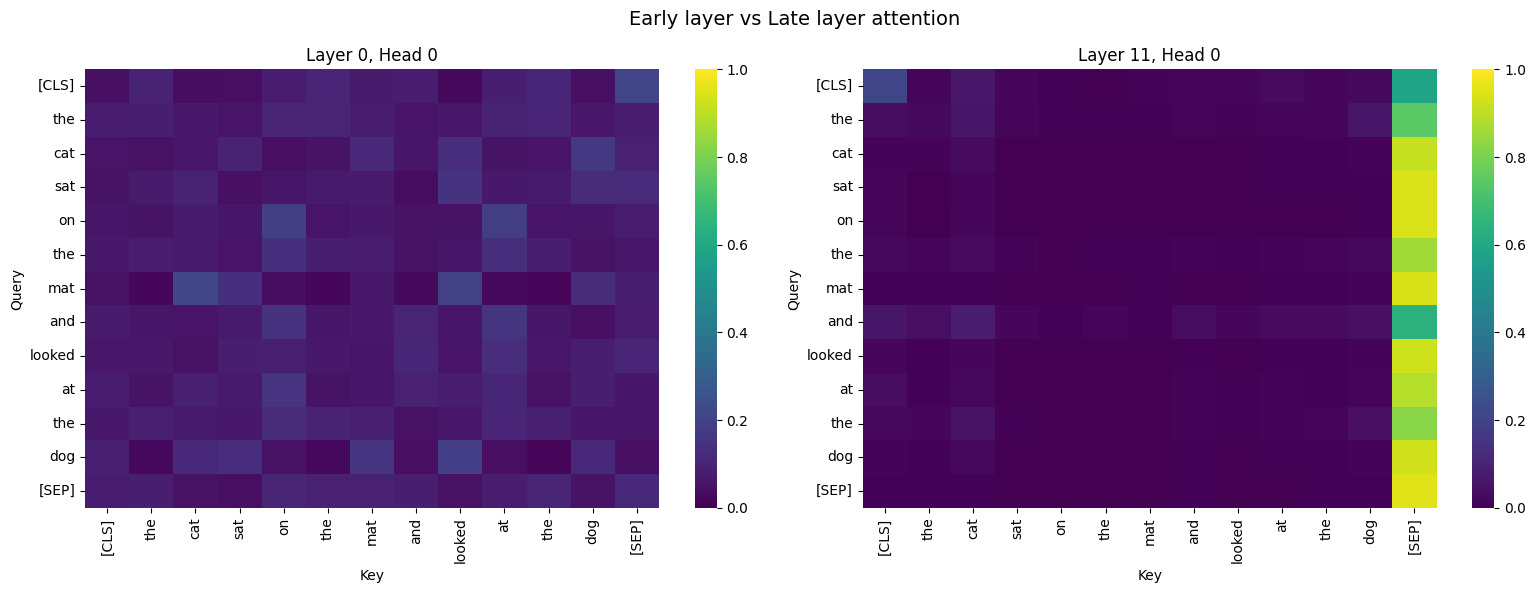

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, layer_idx in enumerate([0, 11]):
    attn_matrix = result["attentions"][layer_idx][0, 0].numpy()
    sns.heatmap(
        attn_matrix,
        xticklabels=result["tokens"],
        yticklabels=result["tokens"],
        cmap="viridis",
        vmin=0,
        vmax=1,
        ax=axes[i],
    )
    axes[i].set_title(f"Layer {layer_idx}, Head 0")
    axes[i].set_xlabel("Key")
    axes[i].set_ylabel("Query")

plt.suptitle("Early layer vs Late layer attention", fontsize=14)
plt.tight_layout()
plt.show()

In [10]:
cls_attention = result["attentions"][11][0, :, 0, :].mean(dim=0).numpy()

token_scores = list(zip(result["tokens"], cls_attention))
token_scores.sort(key=lambda x: x[1], reverse=True)

print("[CLS] attention on last layer (averaged across heads):\n")
for token, score in token_scores:
    bar = "█" * int(score * 50)
    print(f"  {token:15s} {score:.4f} {bar}")

[CLS] attention on last layer (averaged across heads):

  [SEP]           0.2679 █████████████
  [CLS]           0.1005 █████
  dog             0.0949 ████
  cat             0.0789 ███
  at              0.0739 ███
  the             0.0685 ███
  and             0.0623 ███
  looked          0.0617 ███
  the             0.0537 ██
  mat             0.0483 ██
  sat             0.0386 █
  on              0.0262 █
  the             0.0247 █
